In [170]:
import warnings
import pandas as pd
import numpy as np
import xgboost as xgb
import eli5
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import Ridge, Lasso

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings('ignore')

In [215]:
def score_cv(model, train_X, train_y):
    """
    Function that takes in a model and scores it based on cross validation.

    Parameters: 
    model (model): Description of arg1 
    train_X (dataframe): Training Features
    train_y (Series): Labels

    Returns: 
    array: n-folds of scross validation scores.


    """
    n_folds = 5
    model.fit(data_top_X, data_y)
    kf = KFold(n_folds, shuffle=True,
               random_state=42).get_n_splits(train_X.values)
    rmse = np.sqrt(-cross_val_score(model, train_X.values,
                                    train_y, scoring="neg_mean_squared_error", cv=kf))
    print("All folds RMSE is: {}".format(rmse))
    print("The mean RMSE is: {}".format(rmse.mean()))
    return(rmse)

# Problem Statement

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

So what actually contributes to the price of a house? There are the main easy attributes such as square footage, has a pool, neighbourhood, etc. But in truth there is so much more that influences it, and realtors need to understand everything there is to know about it in order to make an accurate price.

With this project I will predict the prices of homes in Ames, Iowa, using 79 exploratory variables.

Let's do it!

# Reading Data

This dataset is derived from a Kaggle Competition and it has 3 different files.

- **train.csv** - The training set with price labels
- **test.csv** - The test set without price labels (used for submission only)
- **data_description.txt** - A text file containing the comprehensive description of all attributes

I will only use the train.csv and not the test. I will provide the scores using cross validation on the train data.

Let's then read the train data.

In [21]:
# Set ID as index
data = pd.read_csv("data.csv", index_col='Id')

Here are some simple statistics of the numerical attributes:

In [22]:
data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


# Data Preprocessing

Here I will proceed to clean and wrangle the data, deal with missing values, and other processing techniques. In this section I will also provide some insights from the newly processed data.

In [23]:
data.sample(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
67,20,RL,NaN,19900,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,PosA,Norm,1Fam,1Story,7,5,1970,1989,Gable,CompShg,Plywood,Plywood,BrkFace,287.0,TA,TA,CBlock,Gd,TA,Gd,GLQ,912,Unf,0,1035,1947,GasA,TA,Y,SBrkr,2207,0,0,2207,1,0,2,0,3,1,TA,7,Min1,1,Gd,Attchd,1970.0,RFn,2,576,TA,TA,Y,301,0,0,0,0,0,NaN,NaN,NaN,0,7,2010,WD,Normal,180000
393,20,RL,NaN,8339,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1959,1959,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,Slab,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,TA,Y,SBrkr,882,0,0,882,0,0,1,0,3,1,TA,5,Typ,0,NaN,Attchd,1959.0,RFn,1,294,TA,TA,Y,0,0,0,0,0,0,NaN,MnPrv,Shed,1200,7,2007,WD,Normal,106500
1380,80,RL,73.0,9735,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,384,384,GasA,Gd,Y,NaN,754,640,0,1394,0,0,2,1,3,1,Gd,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2,400,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal,167500
101,20,RL,NaN,10603,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,7,1977,2001,Gable,CompShg,Plywood,Plywood,BrkFace,28.0,TA,TA,PConc,TA,TA,Mn,ALQ,1200,Unf,0,410,1610,GasA,Gd,Y,SBrkr,1610,0,0,1610,1,0,2,0,3,1,Gd,6,Typ,2,TA,Attchd,1977.0,RFn,2,480,TA,TA,Y,168,68,0,0,0,0,NaN,NaN,NaN,0,2,2010,WD,Normal,205000
549,20,RM,49.0,8235,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,OldTown,Feedr,RRNn,1Fam,1Story,5,7,1955,1995,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,Gd,CBlock,TA,TA,No,LwQ,180,Rec,645,0,825,GasA,TA,Y,SBrkr,825,0,0,825,1,0,1,0,2,1,TA,4,Typ,0,NaN,Detchd,1963.0,RFn,2,720,TA,TA,Y,140,50,0,0,0,0,NaN,MnPrv,NaN,0,6,2008,WD,Normal,125000


In [24]:
data.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object
HeatingQC         object


## DType Change

In [25]:
# MSSubClass is a number and so python automatically reads it as an integer, even 
# though it is a categorical attribute. Same goes for the month and year sold.

cols = ["MSSubClass", "MoSold", "YrSold"]
data[cols] = data[cols].astype(str)

In [26]:
data.dtypes

MSSubClass        object
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object
HeatingQC         object


## Missing Values

Before starting to take insights, let's first take a look on whether we have missing data, and, if so, let's deal with it accordingly.

I will start by creating a dataframe containing the percentage and absolute columns that have missing values:

In [27]:
missing = pd.DataFrame({'Missing %' : (data.isna().sum() / data.shape[0]) * 100, 
                        'Missing' : data.isna().sum() })

missing = missing.loc[missing.Missing > 0]

missing

,Missing %,Missing
LotFrontage,17.739726,259
Alley,93.767123,1369
MasVnrType,0.547945,8
MasVnrArea,0.547945,8
BsmtQual,2.534247,37
BsmtCond,2.534247,37
BsmtExposure,2.602740,38
BsmtFinType1,2.534247,37
BsmtFinType2,2.602740,38
Electrical,0.068493,1


So, it seems we have quite some variables with missing values. 

Next, I am going to deal them one by one.

### Front Lot

##### LotFrontAge (Linear Feet of Street Connected to Property)

The LotFrontage is the linear feet between the property and the street. If we think about it, it should be pretty similar if you are in the same neighbourhood. In that case, I will groupby Neighbourhood and fill the missing values with the median.

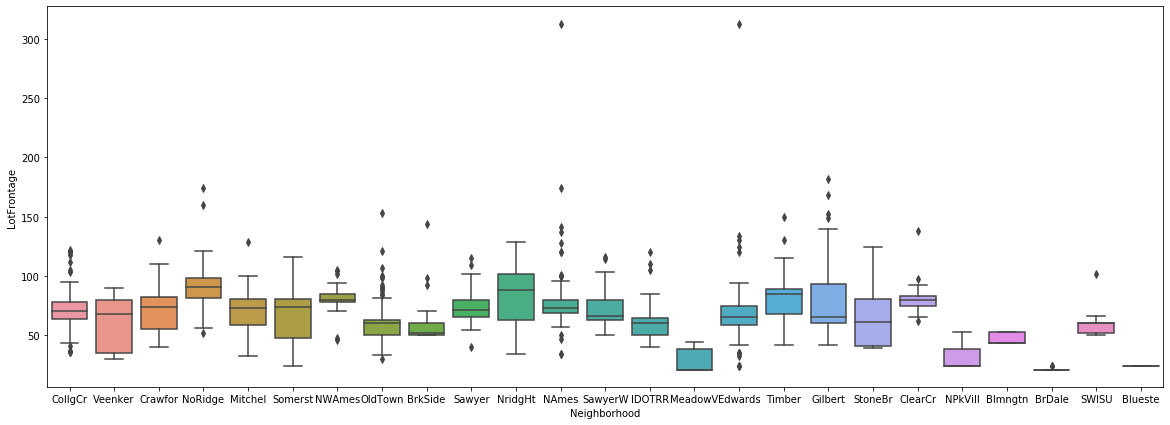

In [28]:
f, ax = plt.subplots(figsize=(20, 7))
sns.boxplot(data=data, x='Neighborhood', y='LotFrontage', ax=ax)

In [29]:
# Filling with the median per neighbourhood
data.LotFrontage = data.groupby("Neighborhood").LotFrontage.transform(lambda x: x.fillna(x.median()))

### Alley

From data_description.txt we see that the Alley attribute describes if there is an alley, and if so, what kind. In this case, if the value is NaN then it means that there is no Alley. I then fill it with "None"

In [30]:
#NaN Means no Alley access so we fill it with "None"

data.Alley.value_counts(dropna=False)

NaN     1369
Grvl      50
Pave      41
Name: Alley, dtype: int64

In [31]:
data.Alley = data.Alley.fillna("None")
data.Alley.value_counts(dropna=False)

None    1369
Grvl      50
Pave      41
Name: Alley, dtype: int64

### Masonry Veneer

#### MasVnrType (Masonry Veneer Type)

In [32]:
# Same applies as above. NaN means "None" (No Masonry Veneer)

data.MasVnrType = data.MasVnrType.fillna("None")
data.MasVnrType.value_counts(dropna=False)

None       872
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

#### MasVnrArea (Masonry Veneer Area in Square Feet)

In this case, it is only NaN if theere is no Masonry Veneer. So we just fill the area as zero.

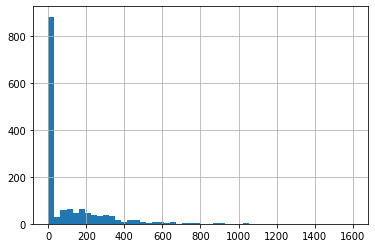

In [33]:
data.MasVnrArea.hist(bins = 50)

In [34]:
data.MasVnrArea = data.MasVnrArea.fillna(0)

### Basement

In all the Basement attributes, NaN means that there is no Basement so we filll all of the missing values to "None" as well

#### BsmtQual (Evaluates the Height of the Basement)

In [35]:
# NA Means No Basement
data.BsmtQual = data.BsmtQual.fillna("None")

#### BsmtCond ( Evaluates the General Condition of the Basement)

In [36]:
#NA means No Basement
data.BsmtCond = data.BsmtCond.fillna("None")

#### BsmtExposure (Refers to walkout or garden level walls)

In [37]:
# NA means no basement
data.BsmtExposure = data.BsmtExposure.fillna("None")

#### BsmtFinType1 (Rating of Basement Finished Area)

In [38]:
# NA means no basement
data.BsmtFinType1 = data.BsmtFinType1.fillna("None")

#### BsmtFinType2 (Rating of Basement Finished Area - if multiple types)

In [39]:
# NA means no basement
data.BsmtFinType2 = data.BsmtFinType2.fillna("None")

### Electrical System

#### Electrical (Electrical System)

In [41]:
data.Electrical.value_counts(dropna=False)

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
NaN         1
Name: Electrical, dtype: int64

In [42]:
# Only one NAN so we can just fill it with the most common one

data.Electrical = data.Electrical.fillna(data.Electrical.mode().values[0])

In [43]:
data.Electrical.value_counts(dropna=False)

SBrkr    1335
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

### Fireplace

#### FireplaceQU (Fireplace Quality)

In [44]:
# NA means no Fireplace so fill to "None"

data.FireplaceQu = data.FireplaceQu.fillna("None")

### Garage

#### GarageType (Garage Location)

In [45]:
# NA means no Garage so fill to "None"

data.GarageType = data.GarageType.fillna("None")

#### GarageYrBlt (Year the Garagee was Built)

In [46]:
data.GarageYrBlt.value_counts(dropna=False).head()

NaN       81
2005.0    65
2006.0    59
2004.0    53
2003.0    50
Name: GarageYrBlt, dtype: int64

In [47]:
# Fill with 0 since NaNs means no Garage
data.GarageYrBlt = data.GarageYrBlt.fillna(0)

#### GarageFinish (Interior Finish of Garage)

In [48]:
# NA means no garage so fill to "None"
data.GarageFinish = data.GarageFinish.fillna("None")

#### GarageCars (Size of garage in car capacity)

In [49]:
# NA means no garage so fill to zero.
data.GarageCars = data.GarageCars.fillna(0)

#### GarageCond (Garage Condition)

In [50]:
# NA means no Garage so fill to "None"
data.GarageCond = data.GarageCond.fillna("None")

#### GarageQual (General Quality)

In [51]:
# NA means no Garage so fill to "None"
data.GarageQual = data.GarageQual.fillna("None")

### Pool

#### PoolQC (Pool Quality)

In [52]:
# Na means no pool so fill to "None"
data.PoolQC = data.PoolQC.fillna("None")

### Fence

In [53]:
# NA means no fence so fill to "None"
data.Fence = data.Fence.fillna("None")

### Misc Feature

In [54]:
# NA means no Misc Feature so fill to "None"
data.MiscFeature = data.MiscFeature.fillna("None")

## Check Missing Values Again

In [55]:
missing = pd.DataFrame({'Missing' : (data.isna().sum() / data.shape[0]) * 100})
missing = missing.loc[missing.Missing > 0]
missing

,Missing


As we can see, all missing values have been dealt with. We are now ready to do some data analytics and geet some insights out of the data.

# Data Insights

## Areas

- How does the areas of the hourse relate to the sale price?

The general understanding is that the bigger the place the more expensive the home is.

Let's see if the data aggres with that.

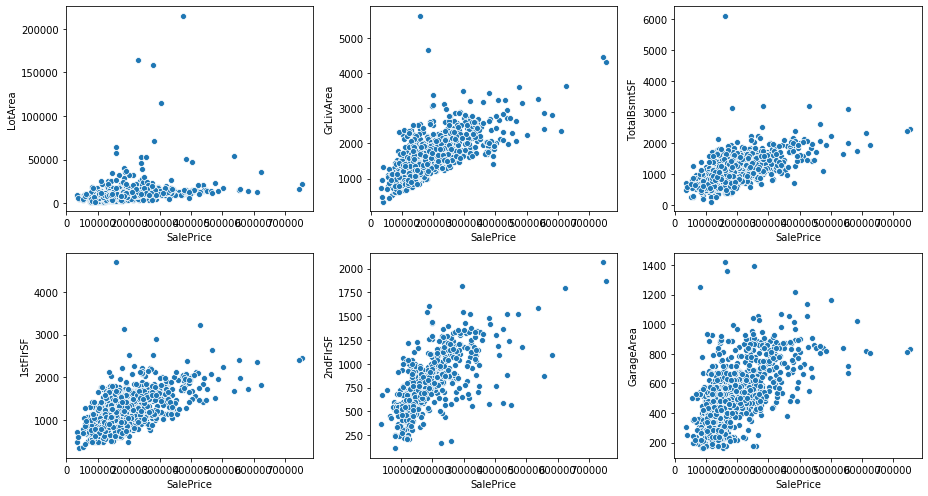

In [69]:
fig, ax =plt.subplots(2,3, figsize=(13,7))

sns.scatterplot(ax=ax[0,0], x="SalePrice", y="LotArea", data=data)
sns.scatterplot(ax=ax[0,1], x="SalePrice", y="GrLivArea", data=data)
sns.scatterplot(ax=ax[0,2], x="SalePrice", y="TotalBsmtSF", data=data[data["TotalBsmtSF"] != 0])
sns.scatterplot(ax=ax[1,0], x="SalePrice", y="1stFlrSF", data=data)
sns.scatterplot(ax=ax[1,1], x="SalePrice", y="2ndFlrSF", data=data[data["2ndFlrSF"] != 0])
sns.scatterplot(ax=ax[1,2], x="SalePrice", y="GarageArea", data=data[data["GarageArea"] != 0])

plt.tight_layout()

We can see that the data clearly indicates a positive relationship between the price and the areas.

## Living Area vs. Sales Price Trend

Again we can see a positive trend. The more living area, the more expensive the house, as expected.

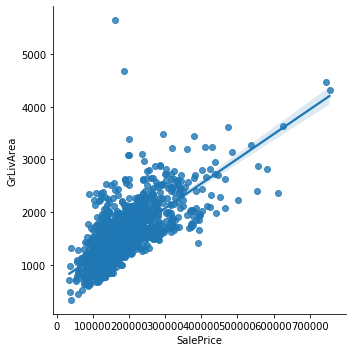

In [70]:
sns.lmplot(x='SalePrice', y='GrLivArea', data=data)

## Living Area vs. MSSubClass vs. Sales Price

- And does the MSSubClass have any relationship to pricee or living area?

Here is the description of the MSSubClass:


        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

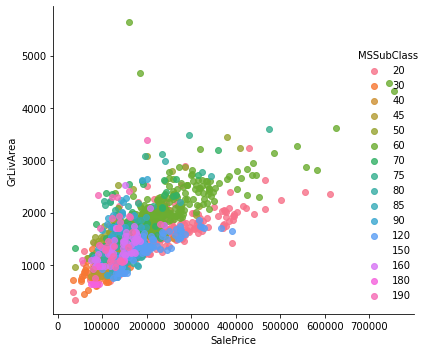

In [72]:
sns.lmplot(x='SalePrice', 
           y='GrLivArea',
           data=data, 
           fit_reg=False, 
           hue='MSSubClass', 
           hue_order = ["20", "30", "40", "45", "50", "60", "70", "75", "80", 
                    "85", "90", "120", "150", "160", "180", "190"])
plt.tight_layout()

It appears to be that way. Bigger MSSubClass (bigger house) tends to comee with a much bigger living area. Plus, the MSSubClass also influences the price greatly.

## Sale Price Distribution

Let's take a look now at the distribution of prices.

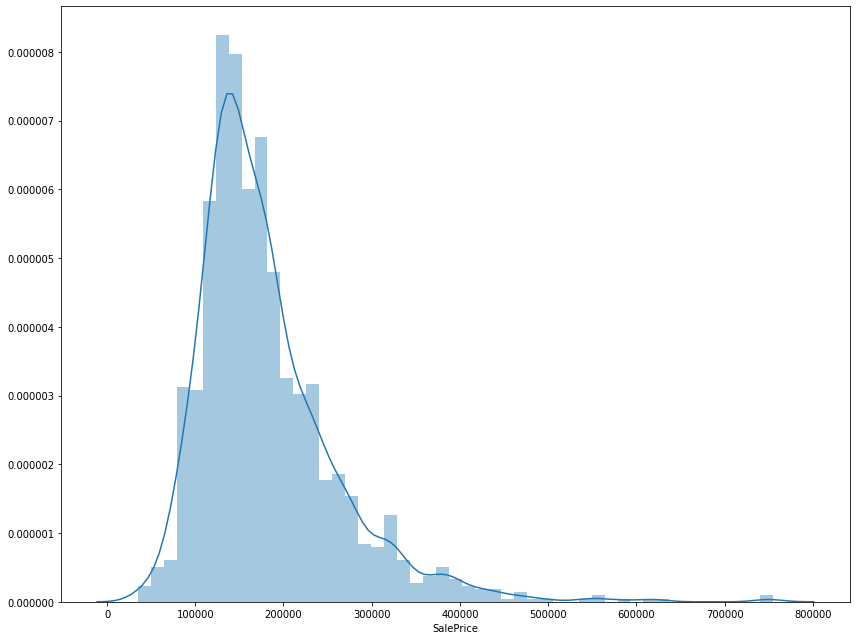

In [75]:
f, ax = plt.subplots(figsize=(12, 9))
sns.distplot(data.SalePrice)
plt.tight_layout()

Hmm... It seems a bit left skewed.. Let's try to transform the price into logarithm and check again.

### Transform Price to Log

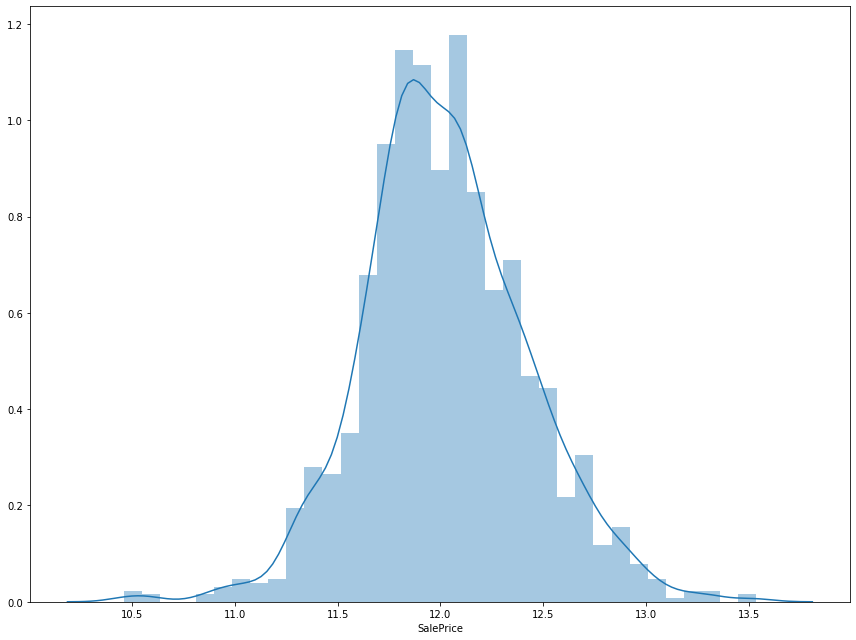

In [78]:
data.SalePrice = np.log1p(data.SalePrice)
f, ax = plt.subplots(figsize=(12, 9))
sns.distplot(data.SalePrice)
plt.tight_layout()

Now that's looking better! Almost normal distribution. This should help us predict the actual values

## Sale Price vs. MSZoning

- How does MSZoning affect the price?

MSZoning description:

       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density

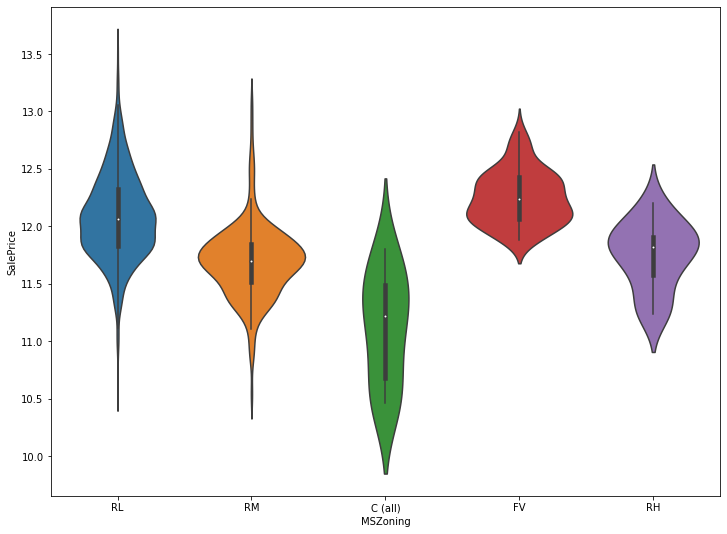

In [79]:
f, ax = plt.subplots(figsize=(12, 9))
sns.violinplot(y='SalePrice', x='MSZoning', data=data)

So it seems that the most "exclusive" and expensive should be the Floating Village Residential Area. Although, Medium and Low density residential areas vary a lot. Some houses might be very expensive and others not.

## Sale Price vs. Neighborhood

- How does the price is distributed between Neighborhoods?

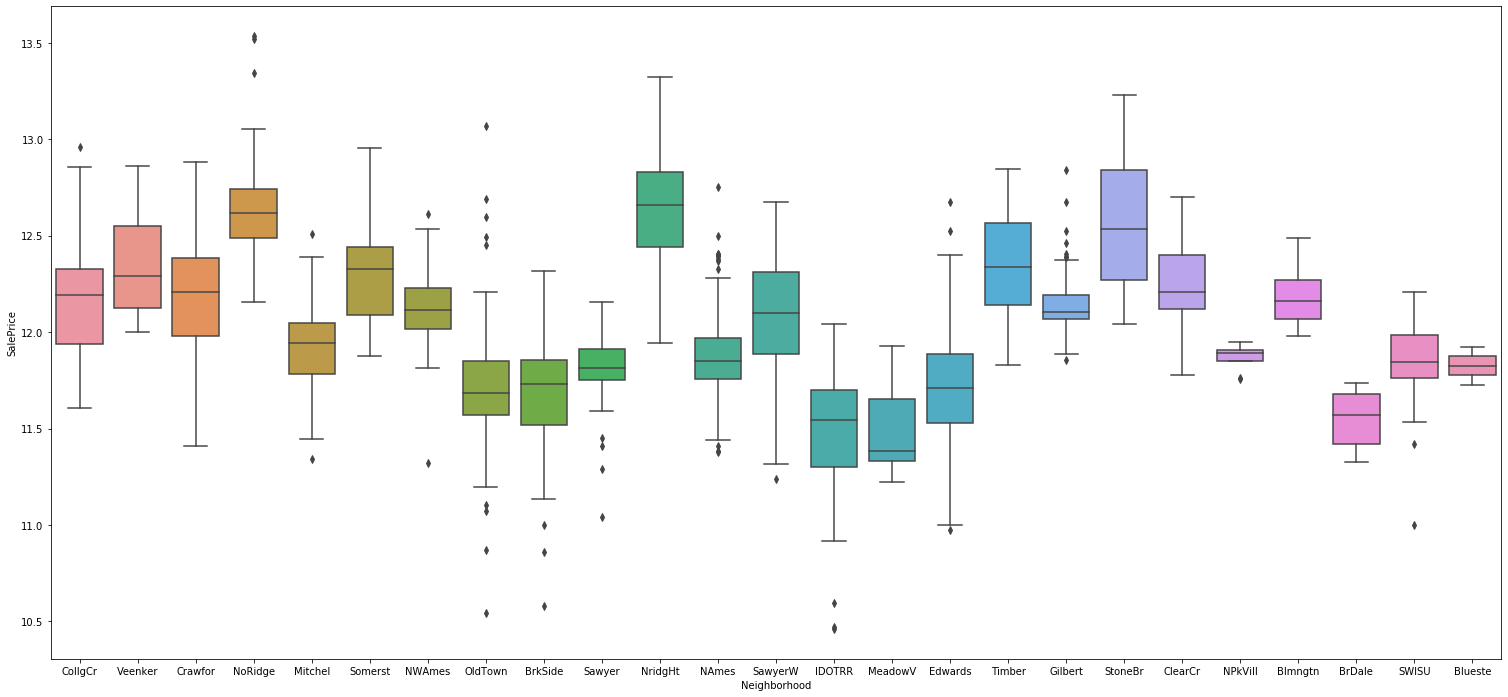

In [270]:
d = pd.concat([data['SalePrice'], data['Neighborhood']], axis=1)
f, ax = plt.subplots(figsize=(26, 12))
fig = sns.boxplot(x='Neighborhood', y="SalePrice", data=d)

Seem that:

- **NridgHt**, **NoRidge** and **StoneBr** are the most expensive neighborhoods 
- **IDOTRR**, **BrDale** and **MeadowV** are the cheapest neighborhoods.

## Sale Price vs. Overall Quality

- How does the Quality impact the price?

Well should be easy to deduce that, the bigger the quality, the more expensive the house, which seems to be in accordance with the graph.

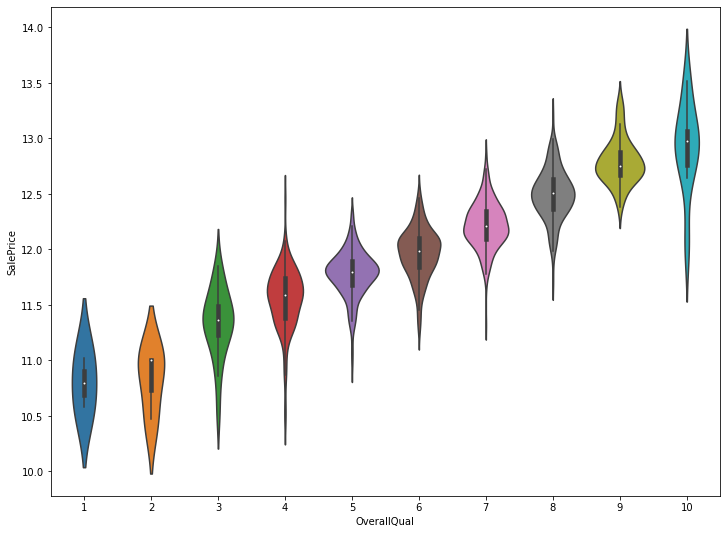

In [80]:
f, ax = plt.subplots(figsize=(12, 9))

sns.violinplot(x='OverallQual', y='SalePrice', data=data)

## Sale Price vs. Year Built vs. Ground Living Area

- How does the Year of Contruction and Living Area Affect the price.

With the next graph, it is possible to see that normally, the price tends to go up the more recent the building and the bigger the liviing area.

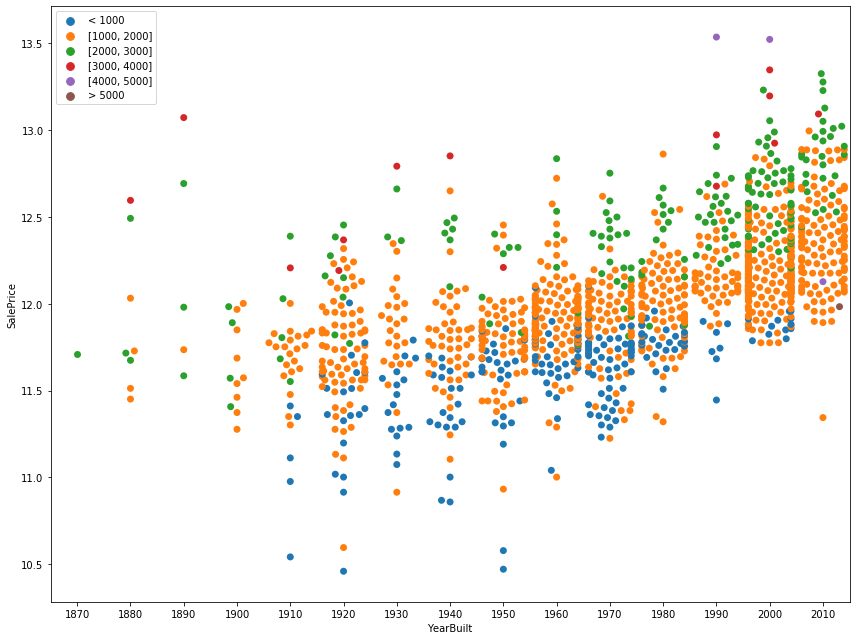

In [82]:
import numpy as np
yearbuilt_seg = np.round(data['YearBuilt'], -1)

def create_bucket(df_liv_area):
    if df_liv_area < 1000:
        return '< 1000'
    if df_liv_area < 2000:
        return '[1000, 2000]'
    if df_liv_area < 3000:
        return '[2000, 3000]'
    if df_liv_area < 4000:
        return '[3000, 4000]'
    if df_liv_area < 5000:
        return '[4000, 5000]'
    return '> 5000'

GrLivAreaSeg = data.apply(lambda row: create_bucket(row.GrLivArea), axis=1)

f, ax = plt.subplots(figsize=(12, 9))
sns.swarmplot(x=yearbuilt_seg, 
              y='SalePrice',
              data=data,  
              hue=GrLivAreaSeg,
              s=7, 
              hue_order=['< 1000', '[1000, 2000]', '[2000, 3000]', '[3000, 4000]', '[4000, 5000]', '> 5000']
             )
plt.tight_layout()


## Sale Price vs. Year Built vs. Overall Quality

- And how does the overall quality factor here?

With the colors we can easily see recent houses tend to be in better quality.

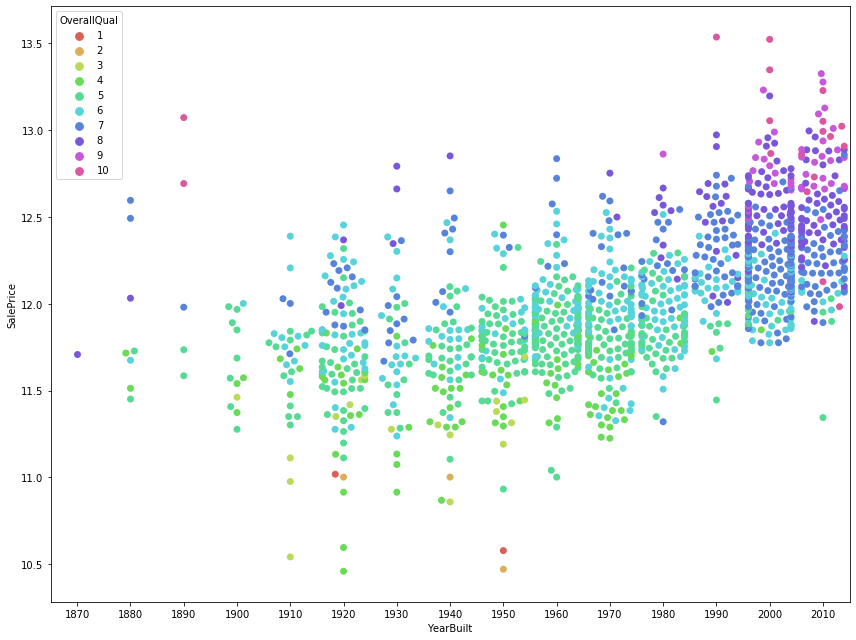

In [83]:
import numpy as np
yearbuilt_seg = np.round(data['YearBuilt'], -1)

def create_bucket(df_liv_area):
    if df_liv_area < 1000:
        return '< 1000'
    if df_liv_area < 2000:
        return '[1000, 2000]'
    if df_liv_area < 3000:
        return '[2000, 3000]'
    if df_liv_area < 4000:
        return '[3000, 4000]'
    if df_liv_area < 5000:
        return '[4000, 5000]'
    return '> 5000'

GrLivAreaSeg = data.apply(lambda row: create_bucket(row.GrLivArea), axis=1)

f, ax = plt.subplots(figsize=(12, 9))
sns.swarmplot(x=yearbuilt_seg, 
              y='SalePrice',
              data=data,  
              hue='OverallQual',
              s=7, 
              palette='hls'
#               hue_order=['1Story', 
#                      '1.5Unf', 
#                      '1.5Fin', 
#                      '2Story', 
#                      '2.5Unf', 
#                      '2.5Fin', 
#                      'SFoyer',
#                      'SLvl']
             )
plt.tight_layout()

### Sale Price vs. Sale Condition vs. Ground Living Area

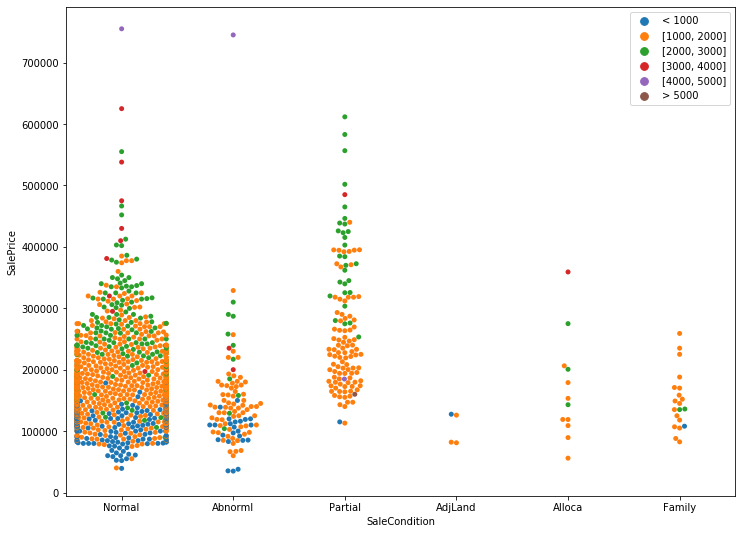

In [255]:
f, ax = plt.subplots(figsize=(12, 9))
sns.swarmplot(x='SaleCondition', 
              y='SalePrice', 
              data=data, 
              hue=GrLivAreaSeg,
              hue_order=['< 1000', '[1000, 2000]', '[2000, 3000]', '[3000, 4000]', '[4000, 5000]', '> 5000']
             )

## Foundation vs. Year Built

- Is the foundation related to the year built?

Seems to be a bit. We can see that Concrete was used throughout the years, but the others were all build in a specific timeframe. Seems that CBlock was discontinued around 1990 and Brick Tile before the 50's. Wooden for a period around the 90's and Stone foundation was used mostly in the last century.

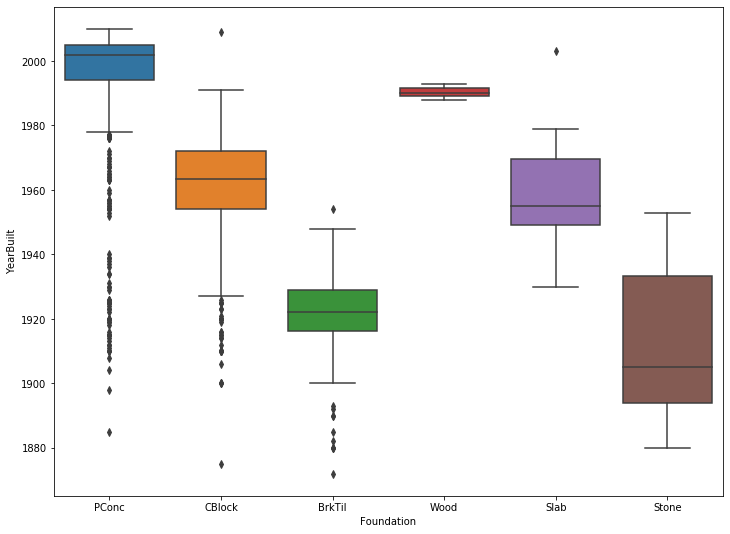

In [85]:
f, ax = plt.subplots(figsize=(12, 9))
sns.boxplot(x='Foundation', y='YearBuilt', data=data)

## Year Remodeled vs. Overall Quality and Condition

- Does a recent remodeling mean better Quality and Condition?

Seems to be in most cases. Specially on the Quality side. If a house was remodeled in the recent years, chances are that its quality and condition are pretty good.

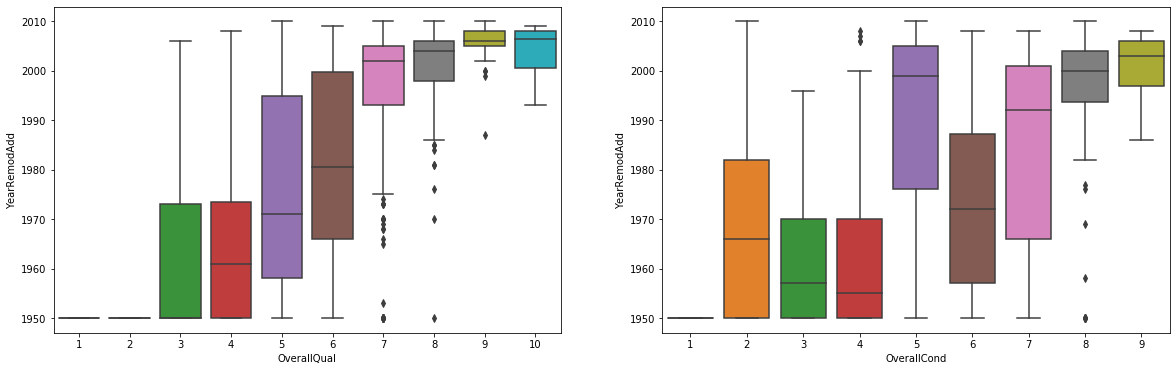

In [86]:
f, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.boxplot(ax=ax[0], x='OverallQual', y='YearRemodAdd', data=data)
sns.boxplot(ax=ax[1], x='OverallCond', y='YearRemodAdd', data=data)

## Number of Bedrooms

- How many bedrooms per house?

Most houses on the market have 3 bedrooms followed by 2 and 4.

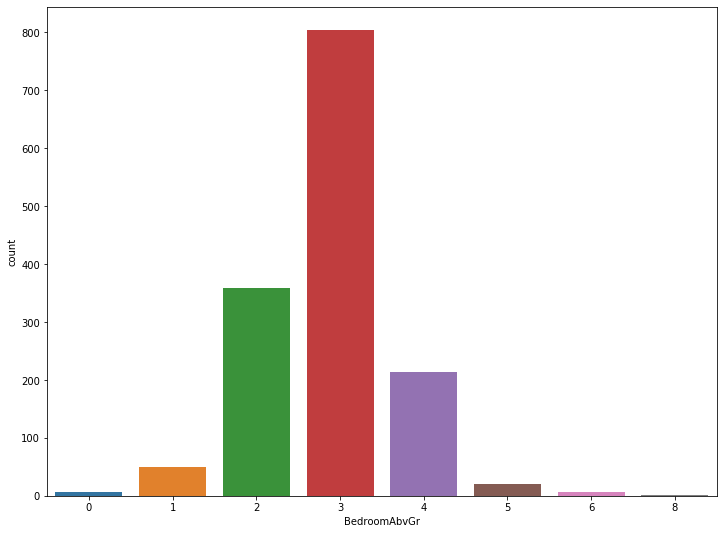

In [88]:
f, ax = plt.subplots(figsize=(12, 9))
sns.countplot(x='BedroomAbvGr', data=data)

## Correlation Matrix

- What are the most correlated features with the SalePrice?

Do find that out we need to compute the correlation matrix.

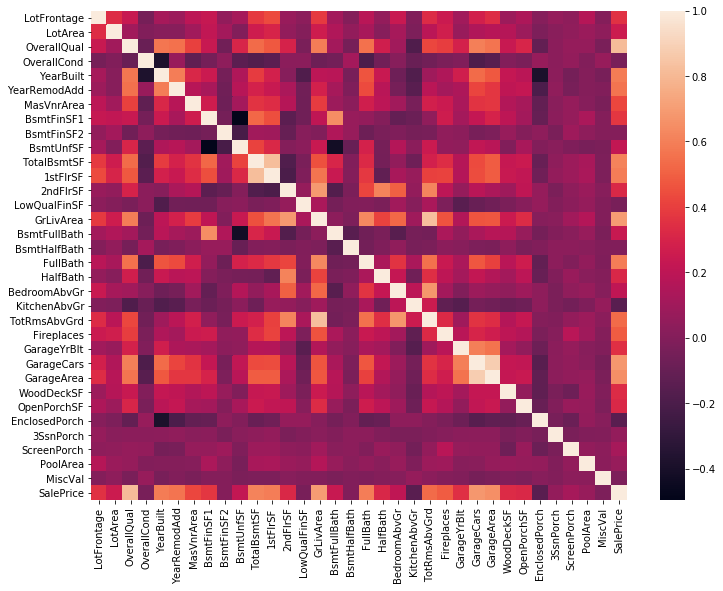

In [89]:
corr = data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr)

### Get top Correlated Features

After computing the matrix we get the features that have a correlation index with SalePrice bigger that 0.25.

In [90]:
top_features = corr.index[abs(corr['SalePrice'])>0.25]

In [91]:
top_features

Index(['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'SalePrice'],
      dtype='object')

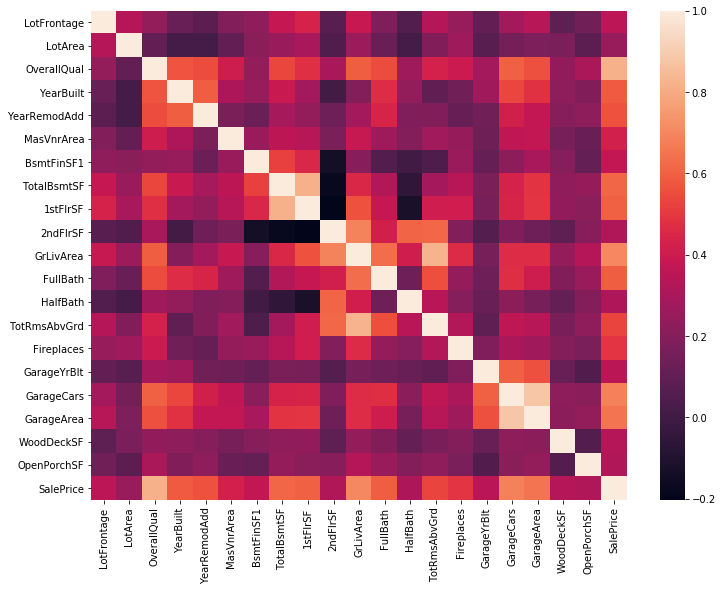

In [92]:
corr = data[top_features].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr)

The most correlated features are:

- LotFrontage 
- LotArea
- OverallQual
- YearBuilt
- YearRemodAdd
- MasVnrArea
- BsmtFinSF1
- TotalBsmtSF
- 1stFlrSF
- 2ndFlrSF
- GrLivArea
- FullBathHalfBath
- TotRmsAbvGrd
- Fireplaces
- GarageYrBlt
- GarageCars
- GarageArea
- WoodDeckSF
- OpenPorchSF

So pretty much the **Square Footages**, **Quality**, **Year build and remodelled** and **Garage**.

# Modelling

Now that we have our data nicely structured, let's start modelling.

1. I will first use the top correlated features found above.
2. Then I will use the whole set of features with One Hot Encoding.
3. At last i will use thee whol set of features with a Label Encoder.


## Only Top Features

In [ ]:
# Snatch the train set with top correlated features and labels

data_top_X = data[top_features].drop("SalePrice", 1)
data_y = data["SalePrice"]
data_top_X.head()

### Model Initialization

I will use 3 different regressors. The **Lasso**, **Ridge** and **XGBoost** Regressor. 

I use them mainly because they prevent overfitting on their own and they allow the usage of several features.

In [ ]:
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror')
ridge_model = Ridge()
lasso_model = Lasso()

### Scoring

I scored the models using cross-validation on the train data, based on the minimum squared error.

#### Ridge Model

In [ ]:
ridge_model_top_features_score = score_cv(ridge_model, data_top_X, data_y)

#### Lasso Model

In [218]:
lasso_model_top_features_score = score_cv(lasso_model, data_top_X, data_y)

All folds RMSE is: [0.16354566 0.19884642 0.17513635 0.18161824 0.26300331]
The mean RMSE is: 0.19642999646193463


#### XGBoost Model

In [219]:
xgb_model_top_features_score = score_cv(xgb_model, data_top_X, data_y)

All folds RMSE is: [0.1322961  0.15603986 0.14404841 0.14285136 0.15022325]
The mean RMSE is: 0.14509179525695534


In [220]:
eli5.explain_weights(xgb_model, top=20)

Weight,Feature
0.3412,GarageCars
0.1295,Fireplaces
0.1149,OverallQual
0.0851,GrLivArea
0.0782,TotalBsmtSF
0.0591,YearRemodAdd
0.0410,YearBuilt
0.0210,1stFlrSF
0.0200,LotArea
0.0191,BsmtFinSF1


Seems that, for the top features

## All Features One Hot Encoding

### Differentiating Columns & One Hot Encoding

In [221]:
# Get all features names 
all_features = data.drop('SalePrice',1).columns.values

# Get categorical and numerical features names
categorical_cols = list(data[all_features].select_dtypes(include=[object]).columns.values)
numerical_cols = list(data[all_features].select_dtypes(exclude=[object]).columns.values)

# Transform into One Hot Encoding
oh = pd.get_dummies(data[categorical_cols])
oh = pd.concat([oh, data[numerical_cols]], axis=1)

# New Training Data
train_X = oh
train_y =  data["SalePrice"]

### Model Initialization

In [222]:
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror')
ridge_model = Ridge()
lasso_model = Lasso()

### Scoring

#### Ridge Model

In [223]:
ridge_model_score = score_cv(ridge_model, train_X, train_y)

All folds RMSE is: [0.12010943 0.15261329 0.14450486 0.11725945 0.18703666]
The mean RMSE is: 0.14430473944093533


#### Lasso Model

In [224]:
lasso_model_score = score_cv(lasso_model, train_X, train_y)

All folds RMSE is: [0.16263399 0.20138972 0.17430763 0.18100976 0.26259301]
The mean RMSE is: 0.19638682187370474


#### XGBoost Model

In [225]:
xgb_model_score = score_cv(xgb_model, train_X, train_y)

All folds RMSE is: [0.11459093 0.14050672 0.13158887 0.12402017 0.13178014]
The mean RMSE is: 0.12849736575111761


In [226]:
eli5.explain_weights(xgb_model, top=20)

Weight,Feature
0.3412,GarageCars
0.1295,Fireplaces
0.1149,OverallQual
0.0851,GrLivArea
0.0782,TotalBsmtSF
0.0591,YearRemodAdd
0.0410,YearBuilt
0.0210,1stFlrSF
0.0200,LotArea
0.0191,BsmtFinSF1


- It seems that using all features is an advantage towards using just a few.
- The best regressor so far is the **XGBoost**.

## All Features With Label Encoding

Having tried with One Hot Encoding, let's try with Label Encoding and see if there is a big difference.

In [ ]:
from sklearn import preprocessing
le=preprocessing.LabelEncoder()

train_labeled = data[categorical_cols].apply(preprocessing.LabelEncoder().fit_transform)

train_labeled = pd.concat([data.drop(categorical_cols, axis=1), train_labeled], axis=1)

### Model Initialization

In [239]:
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror')
ridge_model = Ridge()
lasso_model = Lasso()

### Scoring

#### Ridge Model

In [240]:
ridge_model_labeled_score = score_cv(ridge_model, train_labeled, train_y)

All folds RMSE is: [0.0055769  0.00760781 0.00635438 0.00577865 0.01087189]
The mean RMSE is: 0.007237923452219029


#### Lasso Model

In [241]:
lasso_model_labeled_score = score_cv(lasso_model, train_labeled, train_y)

All folds RMSE is: [0.16263399 0.20138972 0.17430763 0.18100976 0.26259301]
The mean RMSE is: 0.19638682187370474


#### XGBoost Model

In [242]:
xgb_model_labeled_score = score_cv(xgb_model, train_labeled, train_y)

All folds RMSE is: [0.01192373 0.01297675 0.01684454 0.01313003 0.01223882]
The mean RMSE is: 0.013422774417370872


In [243]:
# Weights

eli5.explain_weights(xgb_model, top=20)

Weight,Feature
0.3412,GarageCars
0.1295,Fireplaces
0.1149,OverallQual
0.0851,GrLivArea
0.0782,TotalBsmtSF
0.0591,YearRemodAdd
0.0410,YearBuilt
0.0210,1stFlrSF
0.0200,LotArea
0.0191,BsmtFinSF1


- There is a small difference between the scores. They tend to decrease.
- The only exception is the Ridge Model. There was something wrong there. Probably overfitting. A model that has been performing not so good shouldnt get a big improvement out of changing one hot encoding to label encoding.
- Again, it looks like the XGBoost Model is on the lead.

# Hyperparameter tuning

Since the XGBoost Model had the better scores, I will pick it for the Hyperparameter Tuning phase. Here I will run several models with diferent parameters and check which set of parameters gets better results.

In [244]:
learning_rate = list([0.01,0.05, 0.1, 0.2])
max_depth= list([2, 3, 4])
n_estimators=list([100, 200, 500, 1000, 2000, 5000])

In [247]:
temp = 10000000000
temp2 = 10000000000
for lr in learning_rate:
    for md in max_depth:
        for ne in n_estimators:
            print([lr, md, ne])
            model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.5, learning_rate = lr,
                max_depth = md, alpha = 10, n_estimators = ne, min_child_weight=0.7)
            
            rmse = score_cv(model, train_X, train_y)
            
            if rmse.mean() < temp2:
                temp2=rmse.mean()
                l=lr
                m=md
                n=ne
            

In [246]:
print("BEST PARAMETERS:")
print("Learning Rate: " + str(l))
print("Max Depth: " + str(m))
print("N_Estimators: " + str(n))
print("MSQE: " + str(temp2))

BEST PARAMETERS:
Learning Rate: 0.05
Max Depth: 3
N_Estimators: 1000
MSQE: 0.11888151381582272
